In [48]:
#| echo: false
#| warning: false

import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
import matplotlib_inline.backend_inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

## 5.1 Leave-One-Out Cross-Validation

Load `Auto` data set

In [3]:
df_auto = pd.read_csv("../Data/Auto.csv")

In [7]:
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [8]:
p_order = np.arange(1,11)


# LeaveOneOut CV
reg = linear_model.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df_auto)
scores = list()

for i in p_order:
    poly = preprocessing.PolynomialFeatures(degree = i)
    X_poly = poly.fit_transform(df_auto["horsepower"].values.reshape(-1,1))
    score = cross_val_score(reg, X_poly, df_auto["mpg"], cv = loo, scoring = 'neg_mean_squared_error').mean()
    scores.append(score)

In [11]:
# cross_val_score returns the negative of the MSE

np.array(scores)*-1

array([24.23151352, 19.24821312, 19.33498406, 19.42443031, 19.03321184,
       18.97301274, 19.12563966, 19.22423029, 19.1338565 , 18.94583744])

## 5.2 k-Fold Cross Validation

In [24]:
r_state = np.arange(0,10)
k = 10
elements = len(df_auto)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

reg = linear_model.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = preprocessing.PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df_auto['horsepower'].values.reshape(-1,1))
    kf_10 = KFold(n_splits = k, random_state = Y[i,j], shuffle = True)
    Z[i,j] = cross_val_score(reg, X_poly, df_auto['mpg'], cv = kf_10, scoring = 'neg_mean_squared_error').mean()    

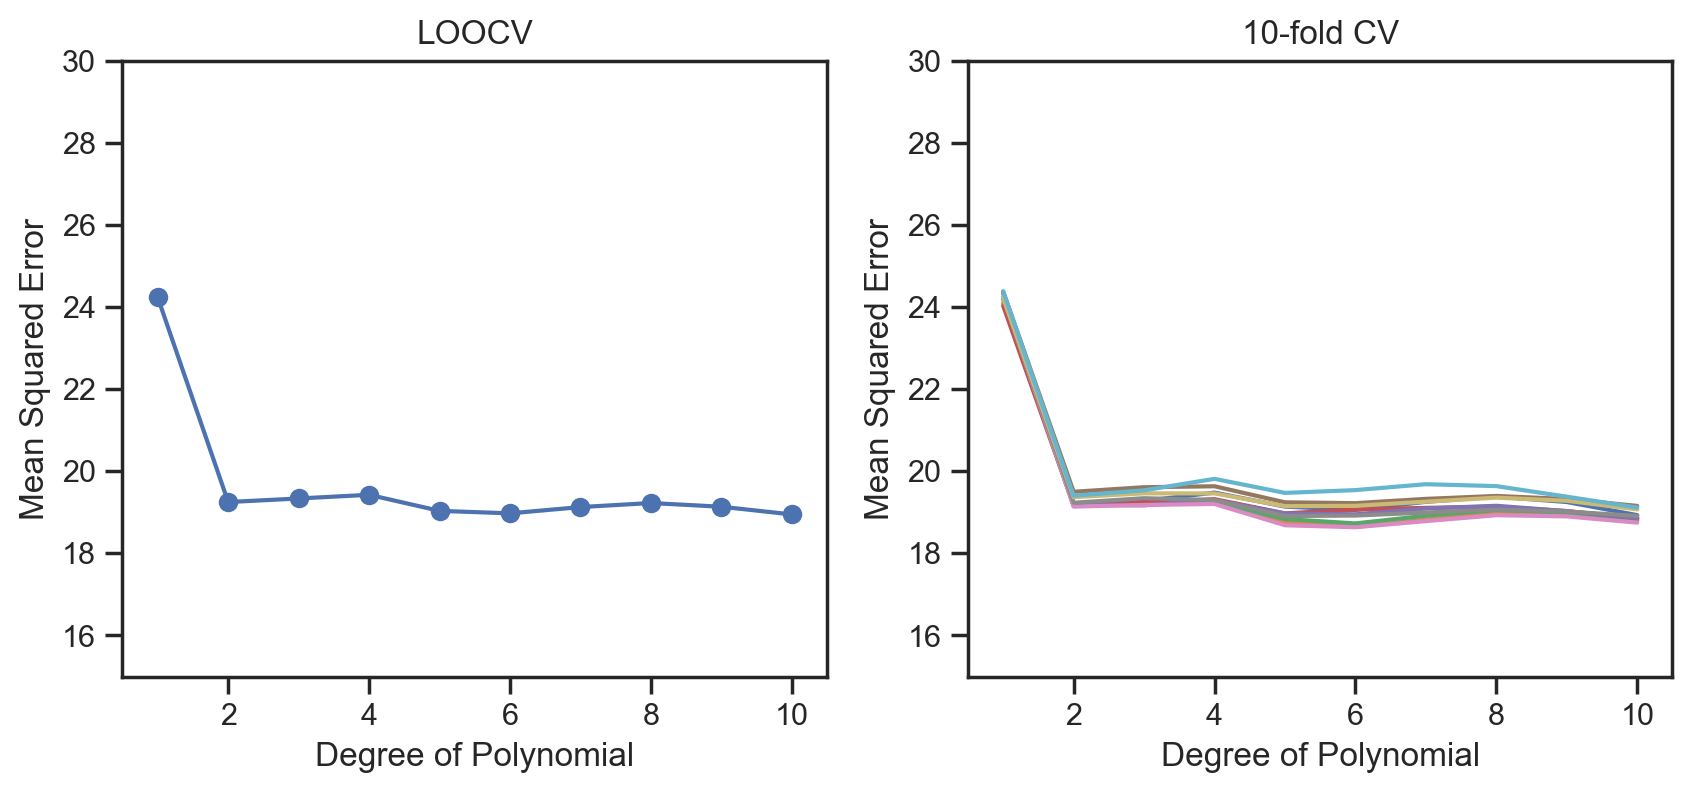

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title(f'{k}-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2))

plt.show()

## 5.3 Lab: Cross-Validation and the Bootstrap

### 5.3.1 The Validation Set Approach

Split the set of observations into two halves, by selecting a random subset of 196 observations out of the original 392 observations

In [37]:
df_train, df_test = train_test_split(df_auto, test_size = 0.5, random_state = 1)
df_train.shape

(196, 9)

Estimate a simple linear regression

In [40]:
mod1 = smf.ols('mpg ~ horsepower', data = df_train).fit()

# calculate the MSE for the test set
mse_mod1 = mean_squared_error(df_test['mpg'], mod1.predict(df_test))
mse_mod1

24.80212062059357

Estimate quadratic and cubic regressions

In [41]:
poly = [2,3]
mse_poly = []

for order in poly:
    mod = smf.ols("mpg ~ horsepower + np.power(horsepower,order)", data = df_train).fit()
    mse_poly.append(mean_squared_error(df_test['mpg'], mod.predict(df_test)))

# calculate the MSE for the test set
mse_poly

[18.848292603275357, 19.11320044972283]

### 5.3.2 Leave-One-Out Cross-Validation

In [44]:
reg = linear_model.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df_auto)

score = cross_val_score(reg, df_auto["horsepower"].values.reshape(-1,1), df_auto["mpg"], cv = loo, scoring = 'neg_mean_squared_error').mean()

In [47]:
# calculate the MSE
score*-1

24.231513517929226

For the multiple polinomial selection with LOOCV see [Section 5.1](#5.1-Leave-One-Out-Cross-Validation)

### 5.3.3 $k$-Fold Cross-Validation

For the multiple polinomial selection with 10-Folda CV see [Section 5.2](#52-k-fold-cross-validation)

### 5.3.4 The Bootstrap

Import `Portfolio` data

In [54]:
df_portfolio = pd.read_csv("../Data/Portfolio.csv", index_col = 0)

In [55]:
df_portfolio.head()

,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983


Calculate a function, `alpha_fun()`, which takes as input the `(X, Y)` data as well as a vector indicating which observations should be used to estimate $\alpha$

In [89]:
X, Y = df_portfolio.iloc[:,0], df_portfolio.iloc[:,1]

In [90]:
def alpha_fun(x, y):
    """
    Function to calculate the alpha 

    x: x values
    y: y values
    start: start index
    end: end index

    returns: estimate for alpha
    """

    return (np.var(y) - np.cov(x,y)[0,1]) / (np.var(x) + np.var(y) - 2*np.cov(x,y)[0,1])

Estimate $\alpha$ using all 100 observations

In [143]:
alpha_fun(X[0:100],Y[0:100]).round(3)

0.577

In [144]:
#calculate 95% bootstrapped confidence interval for median
bootstrap_ci = bootstrap((X, Y), alpha_fun, confidence_level = 0.95, random_state = 1, n_resamples = 1000, vectorized=False, method = 'percentile')
ci_l, ci_u = bootstrap_ci.confidence_interval
bootstrap_mean = (ci_l + ci_u) / 2

print(f'Bootstrap mean: {bootstrap_mean:.4f}')

Bootstrap mean: 0.5345
